In [1]:
# %pip install numpy matplotlib 

In [2]:
# %pip install graphviz

In [3]:
import math
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5
f(3.0)

20.0

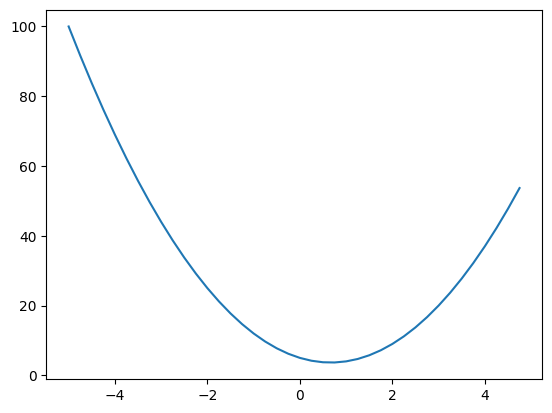

In [5]:
xs = np.arange(-5,5,.25)
ys = f(xs)
plt.plot(xs,ys);

In [6]:
#Getting complex
a=1
b=2
c=3
d=a*b+c
print(d)

5


In [7]:
# Taking the derivative, using infinitesimal limits on addition
h = 0.0001

a=1
b=-2
c=3

d1=a*b+c
c+=h
d2=a*b+c

print('d1 =', d1)
print('d2 =', d2)
print('slope =',(d2-d1)/h)

d1 = 1
d2 = 1.0001000000000002
slope = 1.0000000000021103


##Val

## Value Object

In [48]:
class Value:
    def __init__(self, data, _children = (), _op = '', label=''):
        self.data = data
        self._backward = lambda : None
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self,other):
        out = Value(self.data+ other.data, (self,other), '+')

        def _backward():
            self.grad = 1*out.grad
            other.grad = 1*out.grad

        out._backward = _backward
        return out
    
    def __mul__(self,other):
        out = Value(self.data* other.data, (self,other), '*')

        def _backward():
            self.grad = (other.data)*out.grad
            other.grad  = (self.data)*out.grad

        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1-t**2)*out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        

In [9]:
a = Value(2.0, label  ='a')
b = Value(-3.0,label  ='b')
c= Value(10.0, label  ='c')
e = a*b; e.label = 'e'
d= e + c ; d.label = 'd'
d._prev
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'
L

Value(data = -8.0)

## Graph Renderer

In [10]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

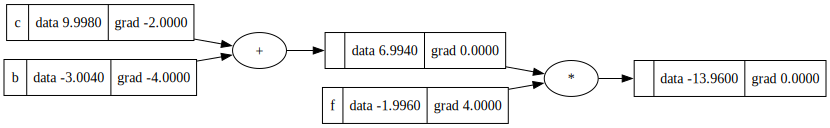

In [15]:
draw_dot(L)

In [12]:
L.grad = 1
d.grad = -2
f.grad = 4

c.grad = -2.0
e.grad = -2.0

a.grad = -3.0*-2.0
b.grad = 2.0 *-2.0

In [13]:
a.data+= .001* a.grad
c.data+= .001* c.grad
f.data+= .001* f.grad
b.data+= .001* b.grad

e = a*b
d = c+b
L = d*f

print(L.data)
 

-13.960023999999999


In [14]:
def lol():
    
    h= 0.001

    a = Value(2.0, label  ='a')
    b = Value(-3.0,label  ='b')
    c= Value(10.0, label  ='c')
    e = a*b; e.label = 'e'
    d= e +c ; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f; L.label = 'L'
    L1= L.data

    a = Value(2.0, label  ='a')
    b = Value(-3.0,label  ='b')
    b.data+=h 
    c= Value(10.0, label  ='c')
    e = a*b; e.label = 'e'
    d= e +c ; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f; L.label = 'L'
    L2= L.data


    print((L2-L1)/h)

lol()

-3.9999999999995595


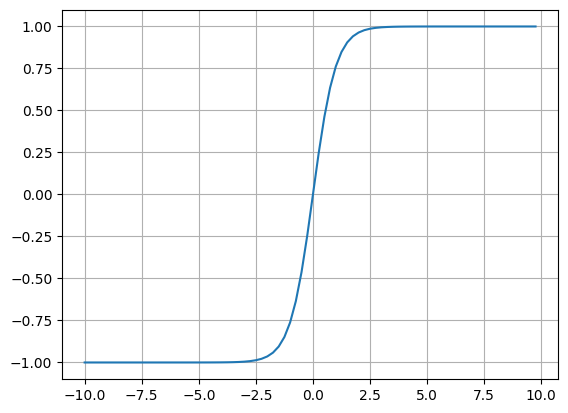

In [19]:
plt.plot(np.arange(-10,10,.25), np.tanh(np.arange(-10,10,.25)))
plt.grid()

In [60]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.887321, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

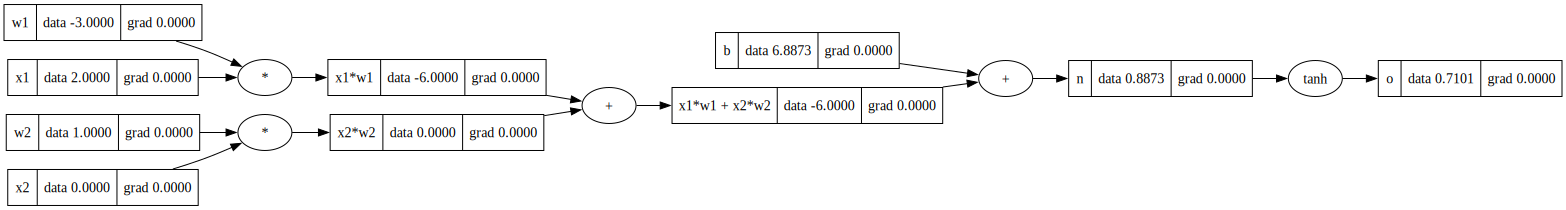

In [61]:
draw_dot(o)

## Topological sort


In [59]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data = 6.887321),
 Value(data = -3.0),
 Value(data = 2.0),
 Value(data = -6.0),
 Value(data = 0.0),
 Value(data = 1.0),
 Value(data = 0.0),
 Value(data = -6.0),
 Value(data = 0.887321),
 Value(data = 0.7100679994889734)]

In [ ]:
o.grad  =1

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

for node in reversed(topo):
    node._backward()

In [62]:
o.grad  =1

In [53]:
o._backward()

In [55]:
n._backward()

In [56]:
x1w1x2w2._backward()

In [57]:
x1w1._backward()
x2w2._backward()

In [44]:
x1.grad = x1w1.grad* w1.data
w1.grad = x1w1.grad* x1.data

In [42]:
x2.grad = x2w2.grad* w2.data
w2.grad = x2w2.grad* x2.data


In [40]:
x1w1x2w2.grad=0.5
b.grad = 0.5
x2w2.grad = .5
x1w1.grad = 0.5

In [36]:
o.grad = 0
n.grad = 0.5 #the local derivative of tanh wrt n